In [18]:
import pandas as pd

from ray import tune
from neuralforecast.core import NeuralForecast
from neuralforecast.auto import AutoNHITS, AutoLSTM
from neuralforecast.losses.pytorch import MQLoss

In [2]:
def create_date_format(
        df: pd.DataFrame, original_date_column: str
    ) -> pd.DataFrame:
        """
        Creates a pandas datetime object from a date string.
        Very specifiy to the output of the mdb notebook yrmo column.
        """
        df["yyyymm"] = df[original_date_column].apply(
            lambda x: str(x)[:4] + "-" + str(x)[4:] + "-01"
        )
        df["yyyymm"] = pd.to_datetime(df.yyyymm)
        return df

In [3]:
df = pd.read_csv('s3://dsaa-cph-ai-s3-dev/jan_rathfelder/impact_data/fra_eylea_20230215.csv')
df = create_date_format(df, 'yrmo')

df_nixtla = df[['cstmr_1_id', 'yyyymm', 'sales_unit']]
df_nixtla.rename(columns={'cstmr_1_id': 'unique_id', 'yyyymm': 'ds', 'sales_unit': 'y'}, inplace=True)

In [35]:
horizon=6

config_lstm = {
    "input_size": tune.choice([horizon, horizon*2, horizon*3]),              # Length of input window
    "encoder_hidden_size": tune.qloguniform(32, 12, q=1),            # Hidden size of LSTM cells
    "encoder_n_layers": tune.randint(2,5),                   # Number of layers in LSTM
    "learning_rate": tune.loguniform(1e-4, 1e-2),             # Initial Learning rate
    "scaler_type": tune.choice(['robust', 'standard']),                   # Scaler type
    "max_steps": tune.randint(500, 1500),                    # Max number of training iterations
    "batch_size": tune.choice([16, 32, 64, 128]),                        # Number of series in batch
    #"random_seed": tune.randint(1, 20),                       # Random seed
}

In [41]:
horizon=6

config_lstm = {
    "input_size": tune.choice([6, 6*2, 6*3]),              # Length of input window
    "encoder_hidden_size": tune.choice([64, 128]),            # Hidden size of LSTM cells
    "encoder_n_layers": tune.choice([2,4]),                   # Number of layers in LSTM
    "learning_rate": tune.loguniform(1e-4, 1e-2),             # Initial Learning rate
    "scaler_type": tune.choice(['robust']),                   # Scaler type
    "max_steps": tune.choice([500, 1000]),                    # Max number of training iterations
    "batch_size": tune.choice([1, 4]),                        # Number of series in batch
    "random_seed": tune.randint(1, 20),                       # Random seed
}

In [58]:
horizon=6

model = [AutoLSTM(h=horizon,
                  config=config_lstm, 
                  loss=MQLoss(),
                  num_samples=25) # number of configurations explored
         ]

In [ ]:
nf = NeuralForecast(
    models=model,
    freq='MS')

val_size  = 18 # 3 x 6 months
test_size = 6 # 1 x 6 months

Y_hat_df = nf.cross_validation(df=df_nixtla, 
                               val_size=val_size,
                               test_size=test_size, 
                               n_windows=None)

(_train_tune pid=9219) Seed set to 19


Epoch 0:  53%|█████▎    | 100/190 [00:00<00:00, 141.83it/s, v_num=0, train_loss_step=0.269]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  10%|█         | 19/190 [00:00<00:00, 213.80it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  11%|█         | 20/190 [00:00<00:00, 214.04it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  11%|█         | 21/190 [00:00<00:00, 214.11it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  23%|██▎       | 43/190 [00:00<00:00, 210.25it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  35%|███▍      | 66/190 [00:00<00:00, 213.66it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  35%|███▌      | 67/190 [00:00<00:00, 213.72it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  36%|███▌      | 68/190 [00:00<00:00, 213.78it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  47%|████▋     | 90/190 [00:00<00:00, 213.89it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  48%|████▊     | 91/190 [00:00<00:00, 213.41i

(_train_tune pid=9219) Seed set to 13


Epoch 0:  13%|█▎        | 100/757 [00:00<00:06, 109.10it/s, v_num=0, train_loss_step=0.118]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   2%|▏         | 12/757 [00:00<00:03, 201.39it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   2%|▏         | 13/757 [00:00<00:03, 201.27it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   4%|▍         | 34/757 [00:00<00:03, 199.61it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   7%|▋         | 55/757 [00:00<00:03, 199.40it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   7%|▋         | 56/757 [00:00<00:03, 198.55it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  10%|█         | 77/757 [00:00<00:03, 198.41it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  13%|█▎        | 98/757 [00:00<00:03, 199.09it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  13%|█▎        | 99/757 [00:00<00:03, 199.10it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  13%|█▎        | 100/757 [00:00<00:03, 199.12

(_train_tune pid=9219) Seed set to 11


Epoch 0:  13%|█▎        | 100/757 [00:00<00:04, 136.00it/s, v_num=0, train_loss_step=0.225]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   1%|▏         | 10/757 [00:00<00:03, 233.69it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   1%|▏         | 11/757 [00:00<00:03, 233.29it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   5%|▍         | 35/757 [00:00<00:03, 231.38it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   5%|▍         | 36/757 [00:00<00:03, 231.19it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   5%|▍         | 37/757 [00:00<00:03, 231.06it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   5%|▌         | 38/757 [00:00<00:03, 230.95it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   8%|▊         | 62/757 [00:00<00:03, 230.92it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   8%|▊         | 63/757 [00:00<00:03, 230.95it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   8%|▊         | 64/757 [00:00<00:03, 230.95i

(_train_tune pid=9219) Seed set to 7


Epoch 0:  10%|█         | 78/757 [00:00<00:07, 90.60it/s, v_num=0, train_loss_step=0.310]
(_train_tune pid=9219) 0.310]
Epoch 0:  13%|█▎        | 100/757 [00:01<00:07, 84.96it/s, v_num=0, train_loss_step=0.510]
(_train_tune pid=9219) 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/757 [00:00<?, ?it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   3%|▎         | 21/757 [00:00<00:03, 201.39it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   3%|▎         | 22/757 [00:00<00:03, 201.40it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   3%|▎         | 23/757 [00:00<00:03, 201.36it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   6%|▌         | 42/757 [00:00<00:07, 100.29it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   6%|▌         | 43/757 [00:00<00:07, 101.18it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   8%|▊         | 64/757 [00:00<00:05, 121.15it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   9%|▊     

(_train_tune pid=9219) Seed set to 14


Epoch 0:  13%|█▎        | 100/757 [00:00<00:06, 103.78it/s, v_num=0, train_loss_step=0.284]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   2%|▏         | 13/757 [00:00<00:03, 202.16it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   2%|▏         | 14/757 [00:00<00:03, 202.05it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   2%|▏         | 15/757 [00:00<00:03, 201.64it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   5%|▍         | 36/757 [00:00<00:03, 201.48it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   5%|▍         | 37/757 [00:00<00:03, 201.43it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   8%|▊         | 58/757 [00:00<00:03, 201.51it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   8%|▊         | 59/757 [00:00<00:03, 201.51it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   8%|▊         | 60/757 [00:00<00:03, 201.51it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  11%|█         | 81/757 [00:00<00:03, 201.69i

(_train_tune pid=9219) Seed set to 12


Epoch 0:  13%|█▎        | 100/757 [00:00<00:05, 126.66it/s, v_num=0, train_loss_step=0.415]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   1%|          | 7/757 [00:00<00:03, 233.96it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   1%|          | 8/757 [00:00<00:03, 233.83it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   1%|          | 9/757 [00:00<00:03, 233.94it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   1%|▏         | 10/757 [00:00<00:03, 234.14it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   5%|▍         | 35/757 [00:00<00:03, 235.34it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   5%|▍         | 36/757 [00:00<00:03, 235.39it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   8%|▊         | 61/757 [00:00<00:02, 235.59it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   8%|▊         | 62/757 [00:00<00:02, 235.60it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   8%|▊         | 63/757 [00:00<00:02, 235.58it/s

(_train_tune pid=9219) Seed set to 10


Epoch 0:  13%|█▎        | 100/757 [00:00<00:06, 106.22it/s, v_num=0, train_loss_step=0.284]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   1%|          | 8/757 [00:00<00:03, 205.33it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   1%|          | 9/757 [00:00<00:03, 204.81it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   1%|▏         | 10/757 [00:00<00:03, 204.42it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   4%|▍         | 32/757 [00:00<00:03, 204.58it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   7%|▋         | 54/757 [00:00<00:03, 204.57it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  10%|▉         | 75/757 [00:00<00:03, 203.99it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  10%|█         | 76/757 [00:00<00:03, 203.89it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  10%|█         | 77/757 [00:00<00:03, 203.81it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  13%|█▎        | 98/757 [00:00<00:03, 203.29it/

(_train_tune pid=9219) Seed set to 17


Epoch 0:  53%|█████▎    | 100/190 [00:00<00:00, 112.63it/s, v_num=0, train_loss_step=0.821]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   3%|▎         | 5/190 [00:00<00:00, 187.94it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  13%|█▎        | 24/190 [00:00<00:00, 187.15it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  13%|█▎        | 25/190 [00:00<00:00, 187.22it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  14%|█▎        | 26/190 [00:00<00:00, 187.14it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  24%|██▍       | 46/190 [00:00<00:00, 187.06it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  35%|███▍      | 66/190 [00:00<00:00, 185.47it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  45%|████▌     | 86/190 [00:00<00:00, 184.50it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  56%|█████▌    | 106/190 [00:00<00:00, 184.75it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  66%|██████▋   | 126/190 [00:00<00:00, 184.99

(_train_tune pid=9219) Seed set to 1


Epoch 0:  53%|█████▎    | 100/190 [00:00<00:00, 106.47it/s, v_num=0, train_loss_step=0.296]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   6%|▌         | 11/190 [00:00<00:01, 170.91it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   6%|▋         | 12/190 [00:00<00:01, 170.96it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  16%|█▌        | 30/190 [00:00<00:00, 170.99it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  25%|██▍       | 47/190 [00:00<00:00, 167.45it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  35%|███▍      | 66/190 [00:00<00:00, 172.23it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  35%|███▌      | 67/190 [00:00<00:00, 172.49it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  36%|███▌      | 68/190 [00:00<00:00, 172.65it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  46%|████▋     | 88/190 [00:00<00:00, 176.05it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  47%|████▋     | 89/190 [00:00<00:00, 176.17i

(_train_tune pid=9219) Seed set to 14


Epoch 0:  13%|█▎        | 100/757 [00:00<00:06, 103.87it/s, v_num=0, train_loss_step=0.259]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   1%|▏         | 10/757 [00:00<00:04, 174.84it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   1%|▏         | 11/757 [00:00<00:04, 168.41it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   4%|▎         | 28/757 [00:00<00:04, 161.36it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   6%|▌         | 47/757 [00:00<00:04, 167.05it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   9%|▉         | 68/757 [00:00<00:03, 176.54it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   9%|▉         | 69/757 [00:00<00:03, 176.88it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   9%|▉         | 70/757 [00:00<00:03, 177.16it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   9%|▉         | 71/757 [00:00<00:03, 177.47it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  12%|█▏        | 93/757 [00:00<00:03, 183.28i

(_train_tune pid=9219) Seed set to 7


Epoch 0:  13%|█▎        | 100/757 [00:00<00:04, 153.06it/s, v_num=0, train_loss_step=0.451]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/757 [00:00<?, ?it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   0%|          | 1/757 [00:00<00:03, 249.82it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   3%|▎         | 26/757 [00:00<00:03, 239.24it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   4%|▎         | 27/757 [00:00<00:03, 239.15it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   4%|▎         | 28/757 [00:00<00:03, 239.18it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   7%|▋         | 53/757 [00:00<00:02, 239.47it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   7%|▋         | 54/757 [00:00<00:02, 239.45it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   7%|▋         | 55/757 [00:00<00:02, 239.42it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   7%|▋         | 56/757 [00:00<00:02, 239.40it/s]
(_trai

(_train_tune pid=9219) Seed set to 5


Epoch 0:  13%|█▎        | 100/757 [00:00<00:05, 116.82it/s, v_num=0, train_loss_step=0.278]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   2%|▏         | 13/757 [00:00<00:03, 205.75it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   5%|▍         | 35/757 [00:00<00:03, 205.52it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   8%|▊         | 57/757 [00:00<00:03, 205.62it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  10%|█         | 78/757 [00:00<00:03, 202.64it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  13%|█▎        | 100/757 [00:00<00:03, 203.39it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  16%|█▌        | 121/757 [00:00<00:03, 203.12it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  16%|█▌        | 122/757 [00:00<00:03, 203.13it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  16%|█▌        | 123/757 [00:00<00:03, 203.15it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  19%|█▉        | 143/757 [00:00<00:03, 20

(_train_tune pid=9219) Seed set to 9


Epoch 0:  53%|█████▎    | 100/190 [00:00<00:00, 123.40it/s, v_num=0, train_loss_step=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   8%|▊         | 15/190 [00:00<00:00, 195.65it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  18%|█▊        | 35/190 [00:00<00:00, 189.48it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  29%|██▉       | 55/190 [00:00<00:00, 191.32it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  29%|██▉       | 56/190 [00:00<00:00, 191.46it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  30%|███       | 57/190 [00:00<00:00, 191.62it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  41%|████      | 78/190 [00:00<00:00, 193.51it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  52%|█████▏    | 99/190 [00:00<00:00, 194.76it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  53%|█████▎    | 100/190 [00:00<00:00, 194.80it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  64%|██████▎   | 121/190 [00:00<00:00, 195.4

(_train_tune pid=9219) Seed set to 15


Epoch 0:  13%|█▎        | 100/757 [00:00<00:03, 170.83it/s, v_num=0, train_loss_step=0.186]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   1%|          | 6/757 [00:00<00:02, 254.37it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   4%|▍         | 33/757 [00:00<00:02, 254.02it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   4%|▍         | 34/757 [00:00<00:02, 253.99it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   8%|▊         | 61/757 [00:00<00:02, 254.03it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  12%|█▏        | 88/757 [00:00<00:02, 254.23it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  12%|█▏        | 89/757 [00:00<00:02, 254.23it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  15%|█▌        | 116/757 [00:00<00:02, 254.31it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  15%|█▌        | 117/757 [00:00<00:02, 254.25it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  19%|█▉        | 144/757 [00:00<00:02, 254.2

(_train_tune pid=9219) Seed set to 13


Epoch 0:  53%|█████▎    | 100/190 [00:00<00:00, 111.22it/s, v_num=0, train_loss_step=0.596]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   7%|▋         | 14/190 [00:00<00:00, 183.81it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  17%|█▋        | 33/190 [00:00<00:00, 183.94it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  18%|█▊        | 34/190 [00:00<00:00, 183.82it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  28%|██▊       | 53/190 [00:00<00:00, 184.11it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  28%|██▊       | 54/190 [00:00<00:00, 184.10it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  38%|███▊      | 73/190 [00:00<00:00, 184.24it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  39%|███▉      | 74/190 [00:00<00:00, 184.24it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  49%|████▉     | 93/190 [00:00<00:00, 184.46it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  49%|████▉     | 94/190 [00:00<00:00, 184.45i

(_train_tune pid=9219) Seed set to 6


Epoch 0:  13%|█▎        | 100/757 [00:00<00:06, 105.25it/s, v_num=0, train_loss_step=0.262]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   3%|▎         | 19/757 [00:00<00:03, 199.10it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   3%|▎         | 20/757 [00:00<00:03, 199.02it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   5%|▌         | 41/757 [00:00<00:03, 198.60it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   6%|▌         | 42/757 [00:00<00:03, 198.14it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   6%|▌         | 43/757 [00:00<00:03, 198.11it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   6%|▌         | 44/757 [00:00<00:03, 198.12it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   6%|▌         | 45/757 [00:00<00:03, 198.09it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   9%|▊         | 66/757 [00:00<00:03, 198.44it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   9%|▉         | 67/757 [00:00<00:03, 198.43i

(_train_tune pid=9219) Seed set to 16


Epoch 0:  53%|█████▎    | 100/190 [00:00<00:00, 133.18it/s, v_num=0, train_loss_step=0.394]
(_train_tune pid=9219) 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/190 [00:00<?, ?it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  11%|█         | 20/190 [00:00<00:00, 193.39it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  11%|█         | 21/190 [00:00<00:00, 193.39it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  12%|█▏        | 22/190 [00:00<00:00, 193.18it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  22%|██▏       | 42/190 [00:00<00:00, 192.54it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  23%|██▎       | 43/190 [00:00<00:00, 192.45it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  23%|██▎       | 44/190 [00:00<00:00, 192.42it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  24%|██▎       | 45/190 [00:00<00:00, 192.34it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  34%|███▍      | 65/190 [00:00<

(_train_tune pid=9219) Seed set to 12


Epoch 0:  53%|█████▎    | 100/190 [00:00<00:00, 112.85it/s, v_num=0, train_loss_step=0.557]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   2%|▏         | 3/190 [00:00<00:01, 175.59it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   2%|▏         | 4/190 [00:00<00:01, 177.65it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   3%|▎         | 5/190 [00:00<00:01, 179.86it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  13%|█▎        | 25/190 [00:00<00:00, 185.17it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  23%|██▎       | 44/190 [00:00<00:00, 184.52it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  24%|██▎       | 45/190 [00:00<00:00, 184.29it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  34%|███▍      | 65/190 [00:00<00:00, 184.94it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  45%|████▍     | 85/190 [00:00<00:00, 185.34it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  55%|█████▍    | 104/190 [00:00<00:00, 184.03it/

(_train_tune pid=9219) Seed set to 10


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  2.21it/s]
                                                                           
Epoch 0:  53%|█████▎    | 100/190 [00:00<00:00, 132.18it/s, v_num=0, train_loss_step=0.263]
(_train_tune pid=9219) 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/190 [00:00<?, ?it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   1%|          | 1/190 [00:00<00:00, 221.11it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  13%|█▎        | 24/190 [00:00<00:00, 218.40it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  13%|█▎        | 25/190 [00:00<00:00, 218.24it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  25%|██▌       | 48/190 [00:00<00:00, 218.11it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  26%|██▌       | 49/190 [00:00<00:00, 218.13it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  38%|███▊      | 72/190 [00:00<00:00, 217.57it/s]
(_train_tune pid=9219) 
Vali

(_train_tune pid=9219) Seed set to 9


Epoch 0:  13%|█▎        | 100/757 [00:00<00:04, 137.47it/s, v_num=0, train_loss_step=0.383]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   3%|▎         | 23/757 [00:00<00:03, 234.38it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   3%|▎         | 24/757 [00:00<00:03, 233.48it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   6%|▋         | 49/757 [00:00<00:03, 233.97it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  10%|▉         | 74/757 [00:00<00:02, 234.10it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  13%|█▎        | 99/757 [00:00<00:02, 234.08it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  16%|█▋        | 124/757 [00:00<00:02, 233.73it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  20%|█▉        | 149/757 [00:00<00:02, 233.67it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  20%|█▉        | 150/757 [00:00<00:02, 233.52it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  20%|█▉        | 151/757 [00:00<00:02, 233

(_train_tune pid=9219) Seed set to 15


Epoch 0:  53%|█████▎    | 100/190 [00:00<00:00, 118.62it/s, v_num=0, train_loss_step=0.300]
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   0%|          | 0/190 [00:00<?, ?it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   1%|          | 1/190 [00:00<00:01, 184.47it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  11%|█         | 21/190 [00:00<00:00, 186.40it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  22%|██▏       | 41/190 [00:00<00:00, 186.77it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  32%|███▏      | 61/190 [00:00<00:00, 186.79it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  43%|████▎     | 81/190 [00:00<00:00, 186.91it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  53%|█████▎    | 100/190 [00:00<00:00, 185.73it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  53%|█████▎    | 101/190 [00:00<00:00, 185.62it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  64%|██████▎   | 121/190 [00:0

(_train_tune pid=9219) Seed set to 5


Epoch 0:  53%|█████▎    | 100/190 [00:00<00:00, 132.18it/s, v_num=0, train_loss_step=0.388]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   8%|▊         | 15/190 [00:00<00:00, 202.31it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   8%|▊         | 16/190 [00:00<00:00, 201.95it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   9%|▉         | 17/190 [00:00<00:00, 201.79it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  20%|██        | 38/190 [00:00<00:00, 200.94it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  21%|██        | 39/190 [00:00<00:00, 199.92it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  31%|███       | 59/190 [00:00<00:00, 194.98it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  42%|████▏     | 80/190 [00:00<00:00, 196.16it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  43%|████▎     | 81/190 [00:00<00:00, 195.48it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  43%|████▎     | 82/190 [00:00<00:00, 194.70i

(_train_tune pid=9219) Seed set to 13


Epoch 0:  53%|█████▎    | 100/190 [00:00<00:00, 112.27it/s, v_num=0, train_loss_step=0.467]
(_train_tune pid=9219) 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/190 [00:00<?, ?it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   1%|          | 1/190 [00:00<00:00, 194.27it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  11%|█         | 20/190 [00:00<00:00, 187.06it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  11%|█         | 21/190 [00:00<00:00, 187.03it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  12%|█▏        | 22/190 [00:00<00:00, 187.06it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  22%|██▏       | 42/190 [00:00<00:00, 186.96it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  33%|███▎      | 62/190 [00:00<00:00, 186.83it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  43%|████▎     | 82/190 [00:00<00:00, 186.71it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  54%|█████▎    | 102/190 [00:00<

(_train_tune pid=9219) Seed set to 19


Epoch 0:  13%|█▎        | 100/757 [00:00<00:04, 157.43it/s, v_num=0, train_loss_step=0.269]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   2%|▏         | 13/757 [00:00<00:03, 230.55it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   5%|▌         | 38/757 [00:00<00:03, 235.29it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   5%|▌         | 39/757 [00:00<00:03, 235.67it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   5%|▌         | 40/757 [00:00<00:03, 236.06it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   7%|▋         | 54/757 [00:00<00:02, 240.66it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   7%|▋         | 55/757 [00:00<00:04, 144.63it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  11%|█         | 80/757 [00:00<00:04, 164.84it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  11%|█         | 81/757 [00:00<00:04, 165.30it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  14%|█▍        | 105/757 [00:00<00:03, 177.02

(_train_tune pid=9219) Seed set to 14


Epoch 0:  13%|█▎        | 100/757 [00:00<00:04, 132.36it/s, v_num=0, train_loss_step=0.237]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   2%|▏         | 12/757 [00:00<00:03, 230.42it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   2%|▏         | 13/757 [00:00<00:03, 230.29it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   2%|▏         | 14/757 [00:00<00:03, 230.54it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   2%|▏         | 15/757 [00:00<00:03, 230.81it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   5%|▌         | 40/757 [00:00<00:03, 233.01it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:   9%|▊         | 65/757 [00:00<00:02, 233.23it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  12%|█▏        | 90/757 [00:00<00:02, 233.54it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  15%|█▌        | 115/757 [00:00<00:02, 233.85it/s]
(_train_tune pid=9219) 
Validation DataLoader 0:  15%|█▌        | 116/757 [00:00<00:02, 233.8

In [61]:
nf.models[0].results.get_best_result().config

{'input_size': 6,
 'encoder_hidden_size': 64,
 'encoder_n_layers': 2,
 'learning_rate': 0.005876642436394127,
 'scaler_type': 'robust',
 'max_steps': 500,
 'batch_size': 1,
 'random_seed': 15,
 'h': 6,
 'loss': MQLoss(),
 'valid_loss': MQLoss()}

In [50]:
Y_hat_df.head(2)

unique_id                   ds     cutoff  AutoLSTM-median  AutoLSTM-lo-90   
0         -  2022-06-01 00:00:00 2022-05-01        -0.040269       -1.723868  \
1         -  2022-07-01 00:00:00 2022-05-01         0.140248       -1.942907   

   AutoLSTM-lo-80  AutoLSTM-hi-80  AutoLSTM-hi-90    y  
0       -1.301523        1.468377        2.261859  0.0  
1       -1.446680        2.432237        3.716288  0.0

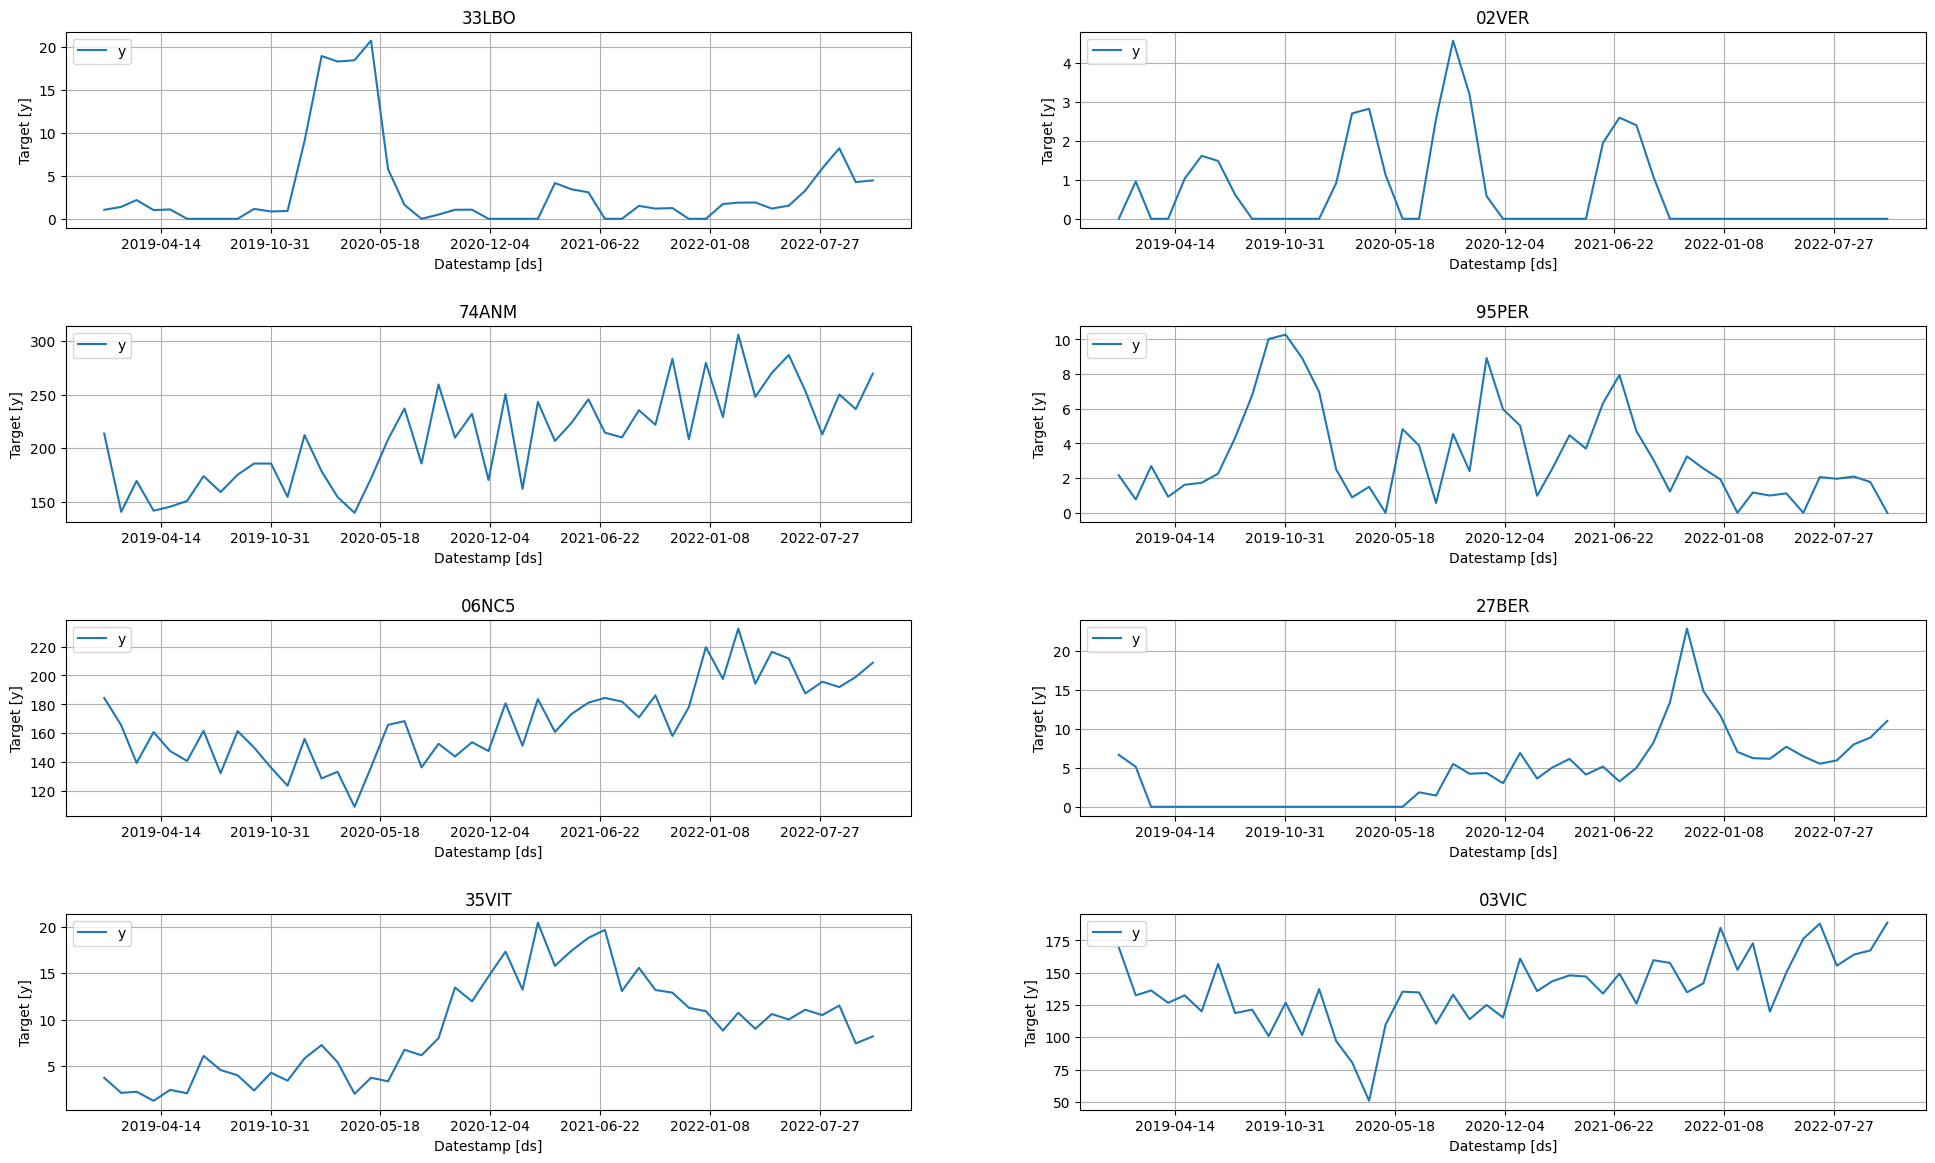

In [62]:
from statsforecast import StatsForecast

StatsForecast.plot(df_nixtla, engine='matplotlib')

In [64]:
Y_hat_df.head(2)

unique_id                   ds     cutoff  AutoLSTM-median  AutoLSTM-lo-90   
0         -  2022-06-01 00:00:00 2022-05-01        -0.556803       -2.388682  \
1         -  2022-07-01 00:00:00 2022-05-01        -0.202857       -2.211529   

   AutoLSTM-lo-80  AutoLSTM-hi-80  AutoLSTM-hi-90    y  
0       -1.994014        1.810047        2.706416  0.0  
1       -1.738144        2.293247        3.326743  0.0

In [68]:
y_true = Y_hat_df.y.values
y_hat = Y_hat_df['AutoLSTM-median'].values

n_series = len(df_nixtla.unique_id.unique())

y_true = y_true.reshape(n_series, -1, horizon)
y_hat = y_hat.reshape(n_series, -1, horizon)

print('Parsed results')
print('2. y_true.shape (n_series, n_windows, n_time_out):\t', y_true.shape)
print('2. y_hat.shape  (n_series, n_windows, n_time_out):\t', y_hat.shape)

Parsed results
2. y_true.shape (n_series, n_windows, n_time_out):	 (757, 1, 6)
2. y_hat.shape  (n_series, n_windows, n_time_out):	 (757, 1, 6)


In [69]:
from neuralforecast.losses.numpy import mae, mse, smape, mape

print('MAE: ', mae(y_hat, y_true))
print('MSE: ', mse(y_hat, y_true))
print('mape: ', mape(y_hat, y_true))
print('smape: ', smape(y_hat, y_true))

MAE:  20.350472220795513
MSE:  1539.5003640464784
mape:  4.890541151010382
smape:  0.6443575883433366


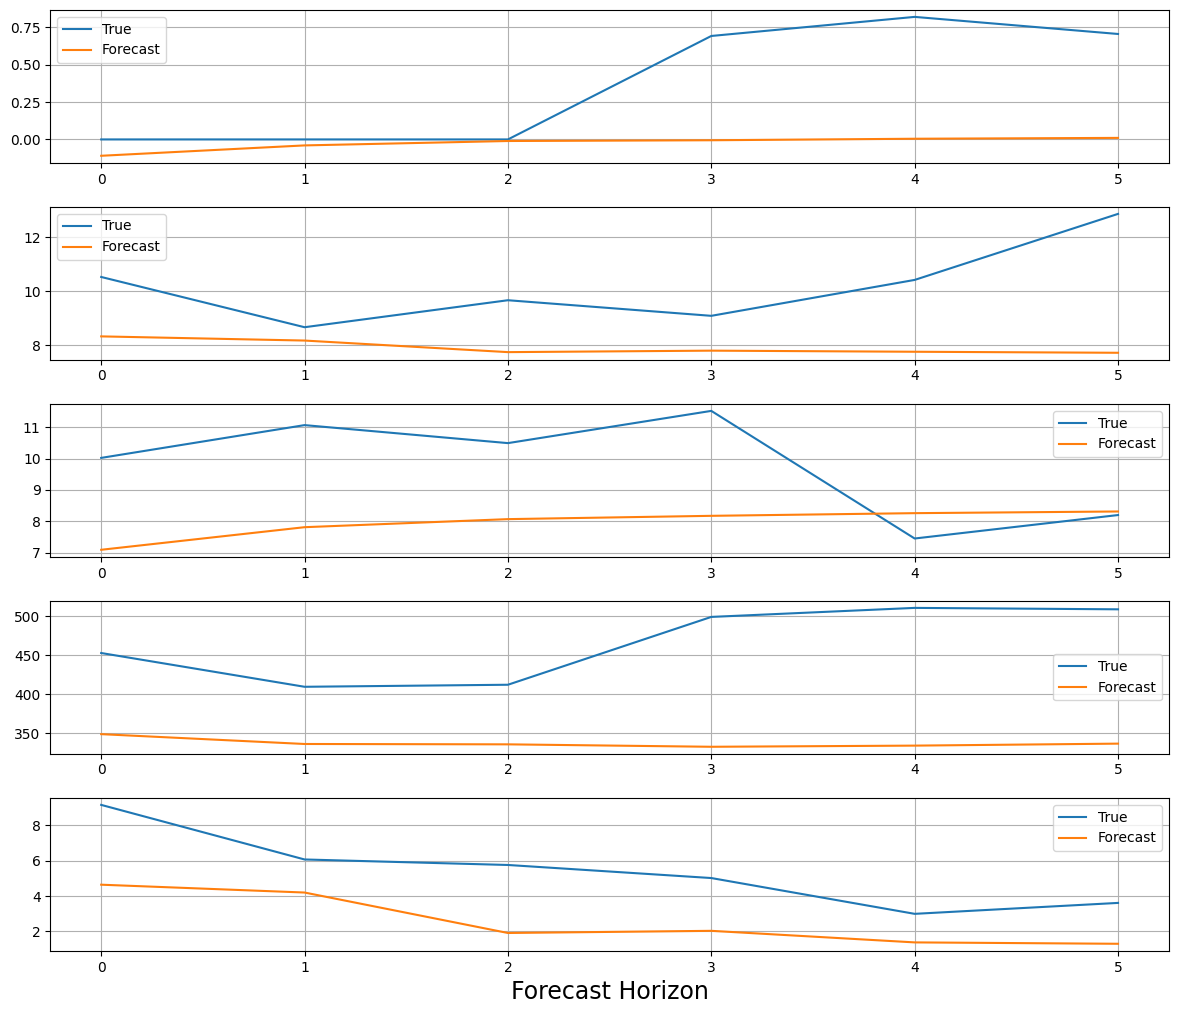

In [70]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(12, 10))
fig.tight_layout()

for idx, w_idx in enumerate(np.random.choice(len(y_hat), 5, replace=False)):
    axs[idx].plot(y_true[w_idx, 0,:],label='True')
    axs[idx].plot(y_hat[w_idx, 0,:],label='Forecast')
    axs[idx].grid()
    if idx==4:
        axs[idx].set_xlabel('Forecast Horizon', fontsize=17)
    axs[idx].legend()

plt.show()
plt.close()

In [71]:
fcst_df = nf.predict()

fcst_df.columns = fcst_df.columns.str.replace('-median', '')
fcst_df.head()

Predicting: |          | 0/? [00:00<?, ?it/s]

ds  AutoLSTM  AutoLSTM-lo-90  AutoLSTM-lo-80   
unique_id                                                        
-         2022-12-01 -0.103088       -0.989316       -0.672086  \
-         2023-01-01 -0.013034       -1.140800       -0.795061   
-         2023-02-01  0.175146       -1.324322       -0.911627   
-         2023-03-01  0.229716       -1.361663       -0.946010   
-         2023-04-01  0.274909       -1.452132       -1.027040   

           AutoLSTM-hi-80  AutoLSTM-hi-90  
unique_id                                  
-                0.971471        1.466267  
-                1.323223        1.938954  
-                1.797675        2.532691  
-                1.933377        2.727384  
-                2.085482        2.959382

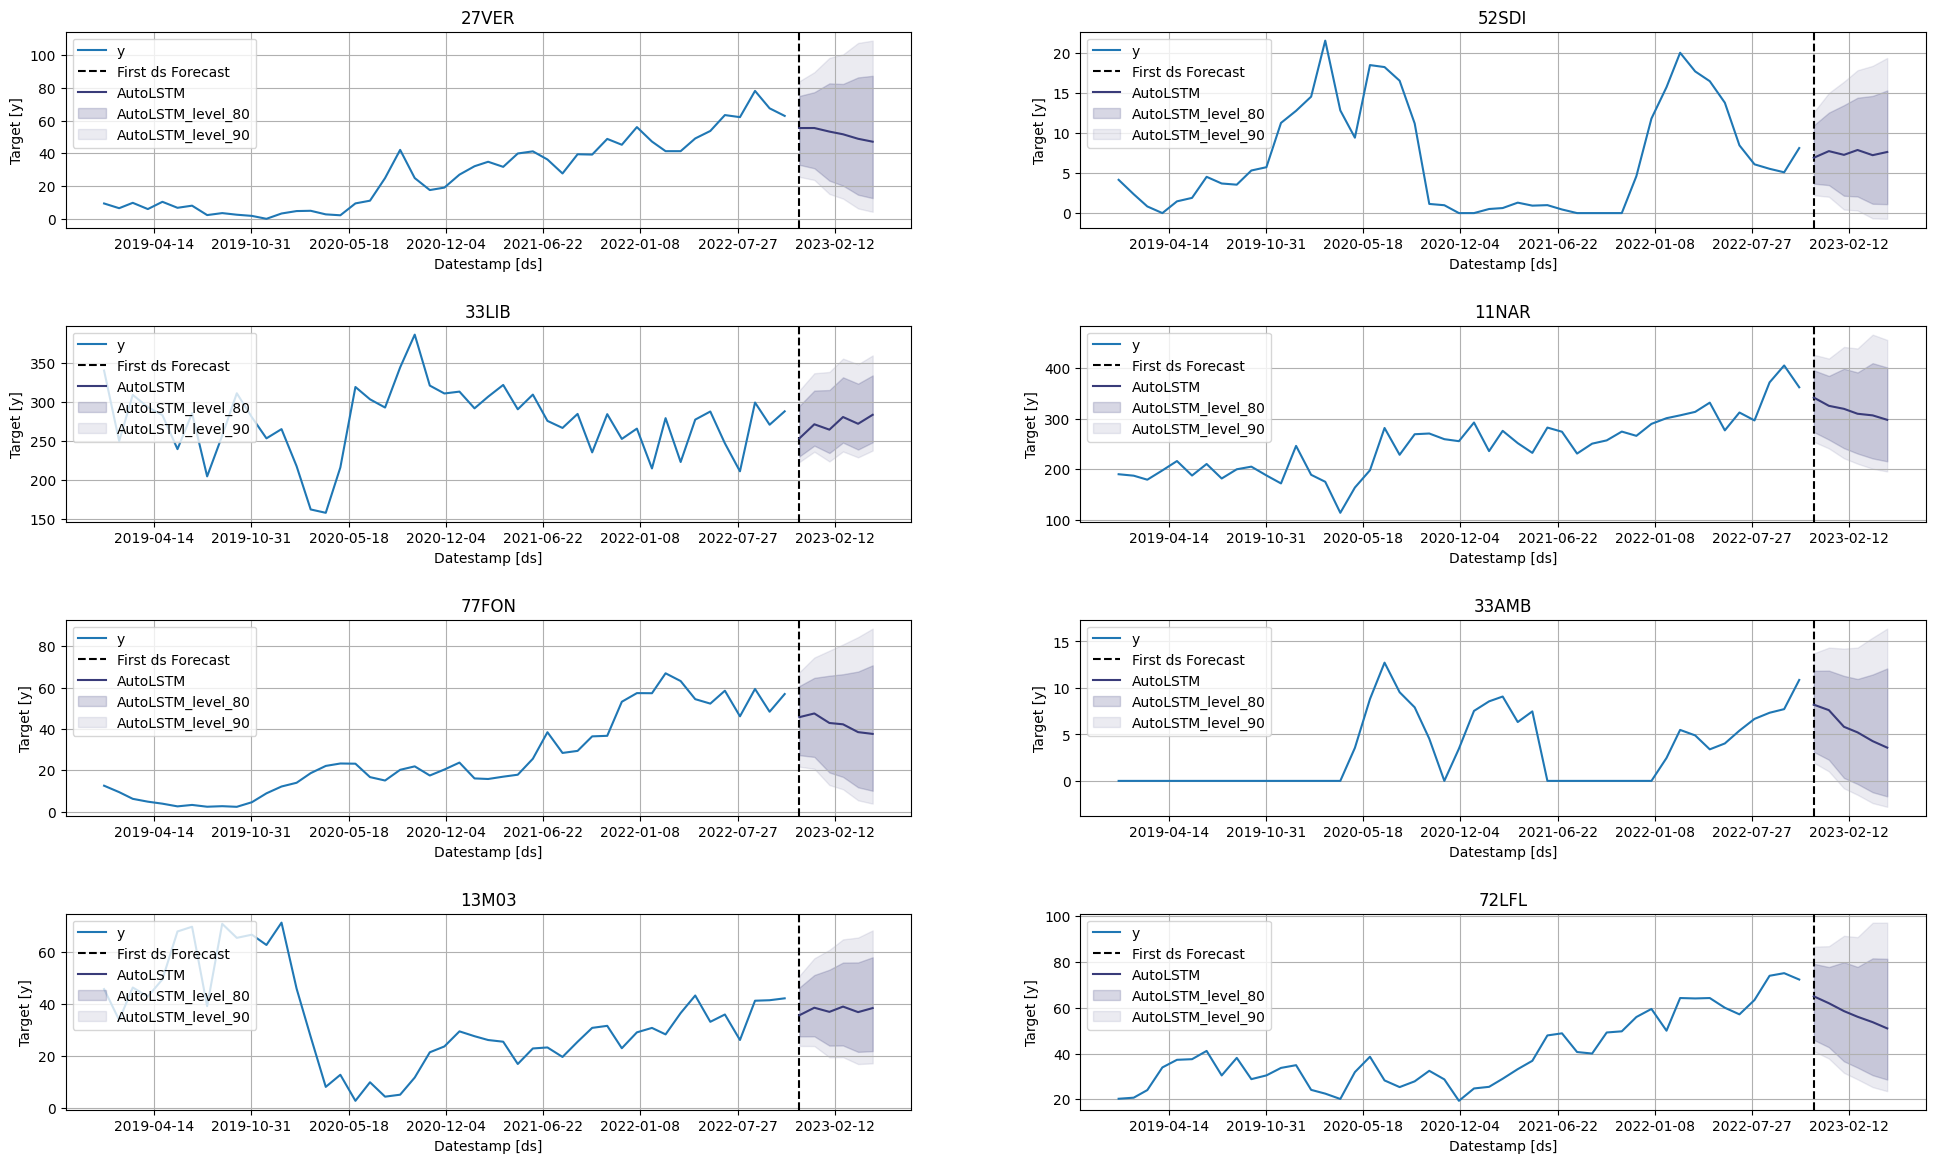

In [74]:
StatsForecast.plot(df_nixtla, fcst_df, engine='matplotlib', max_insample_length=48, level=[80, 90])